In [78]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

In [79]:
from datetime import datetime, timedelta
from prophet import Prophet #prophet 라이브러리 불러오기

from prophet.diagnostics import cross_validation
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import performance_metrics

In [80]:
df = pd.read_csv("/Users/hj/Documents/무제/심화 프로젝트/data/train_train.csv", sep=',')
df

,ID,timestamp,item,corporation,location,supply(kg),price(원/kg)
0,TG_A_J_20190101,2019-01-01,TG,A,J,0.0,0.0
1,TG_A_J_20190102,2019-01-02,TG,A,J,0.0,0.0
2,TG_A_J_20190103,2019-01-03,TG,A,J,60601.0,1728.0
3,TG_A_J_20190104,2019-01-04,TG,A,J,25000.0,1408.0
4,TG_A_J_20190105,2019-01-05,TG,A,J,32352.0,1250.0
...,...,...,...,...,...,...,...
43948,RD_F_J_20220127,2022-01-27,RD,F,J,522900.0,536.0
43949,RD_F_J_20220128,2022-01-28,RD,F,J,435800.0,588.0
43950,RD_F_J_20220129,2022-01-29,RD,F,J,422700.0,623.0
43951,RD_F_J_20220130,2022-01-30,RD,F,J,484440.0,481.0


In [81]:
test_df = pd.read_csv("/Users/hj/Documents/무제/심화 프로젝트/data/train_test.csv", sep=',')
test_df

,ID,timestamp,item,corporation,location,supply(kg),price(원/kg)
0,TG_A_J_20220201,2022-02-01,TG,A,J,0.0,0.0
1,TG_A_J_20220202,2022-02-02,TG,A,J,0.0,0.0
2,TG_A_J_20220203,2022-02-03,TG,A,J,0.0,0.0
3,TG_A_J_20220204,2022-02-04,TG,A,J,535.5,6065.0
4,TG_A_J_20220205,2022-02-05,TG,A,J,5893.0,3113.0
...,...,...,...,...,...,...,...
1087,RD_F_J_20220224,2022-02-24,RD,F,J,478500.0,532.0
1088,RD_F_J_20220225,2022-02-25,RD,F,J,568800.0,520.0
1089,RD_F_J_20220226,2022-02-26,RD,F,J,478320.0,509.0
1090,RD_F_J_20220227,2022-02-27,RD,F,J,0.0,0.0


In [82]:
import datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])
test_df['timestamp'] = pd.to_datetime(test_df['timestamp'])

import holidays
date_list=pd.date_range(start='20190101', end='20230228', freq='D')

# 한국 휴일 객체 생성 
kr_holidays = holidays.KR()
holiday_df = pd.DataFrame(columns=['ds','holiday'])
holiday_df['ds'] = sorted(date_list)
holiday_df['holiday'] = holiday_df.ds.apply(lambda x: 'holiday' if x in kr_holidays else 'non-holiday')


In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43953 entries, 0 to 43952
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   ID           43953 non-null  object        
 1   timestamp    43953 non-null  datetime64[ns]
 2   item         43953 non-null  object        
 3   corporation  43953 non-null  object        
 4   location     43953 non-null  object        
 5   supply(kg)   43953 non-null  float64       
 6   price(원/kg)  43953 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(4)
memory usage: 2.3+ MB


In [84]:
# timestamp : year / month / day 쪼개기

df['year'] = df['timestamp'].dt.year
df['month'] = df['timestamp'].dt.month
df['day'] = df['timestamp'].dt.day
df['dayofweek'] = df['timestamp'].dt.dayofweek  ## 무슨요일인지 확인 

test_df['year'] = test_df['timestamp'].dt.year
test_df['month'] = df['timestamp'].dt.month
test_df['day'] = df['timestamp'].dt.day
test_df['dayofweek'] = test_df['timestamp'].dt.dayofweek

df

,ID,timestamp,item,corporation,location,supply(kg),price(원/kg),year,month,day,dayofweek
0,TG_A_J_20190101,2019-01-01,TG,A,J,0.0,0.0,2019,1,1,1
1,TG_A_J_20190102,2019-01-02,TG,A,J,0.0,0.0,2019,1,2,2
2,TG_A_J_20190103,2019-01-03,TG,A,J,60601.0,1728.0,2019,1,3,3
3,TG_A_J_20190104,2019-01-04,TG,A,J,25000.0,1408.0,2019,1,4,4
4,TG_A_J_20190105,2019-01-05,TG,A,J,32352.0,1250.0,2019,1,5,5
...,...,...,...,...,...,...,...,...,...,...,...
43948,RD_F_J_20220127,2022-01-27,RD,F,J,522900.0,536.0,2022,1,27,3
43949,RD_F_J_20220128,2022-01-28,RD,F,J,435800.0,588.0,2022,1,28,4
43950,RD_F_J_20220129,2022-01-29,RD,F,J,422700.0,623.0,2022,1,29,5
43951,RD_F_J_20220130,2022-01-30,RD,F,J,484440.0,481.0,2022,1,30,6


In [85]:
df = df.rename(columns={'timestamp': 'ds', 'price(원/kg)':'y'})
test_df = test_df.rename(columns={'timestamp': 'ds', 'price(원/kg)':'y'})


In [86]:
# holiday_df의 'ds'와 'holiday' 컬럼을 기존의 df 데이터프레임에 추가
df['holiday'] = df['ds'].apply(lambda x: holiday_df[holiday_df['ds'] == x]['holiday'].values[0] if x in holiday_df['ds'].values else 'non-holiday')

# 결과 확인
df


,ID,ds,item,corporation,location,supply(kg),y,year,month,day,dayofweek,holiday
0,TG_A_J_20190101,2019-01-01,TG,A,J,0.0,0.0,2019,1,1,1,holiday
1,TG_A_J_20190102,2019-01-02,TG,A,J,0.0,0.0,2019,1,2,2,non-holiday
2,TG_A_J_20190103,2019-01-03,TG,A,J,60601.0,1728.0,2019,1,3,3,non-holiday
3,TG_A_J_20190104,2019-01-04,TG,A,J,25000.0,1408.0,2019,1,4,4,non-holiday
4,TG_A_J_20190105,2019-01-05,TG,A,J,32352.0,1250.0,2019,1,5,5,non-holiday
...,...,...,...,...,...,...,...,...,...,...,...,...
43948,RD_F_J_20220127,2022-01-27,RD,F,J,522900.0,536.0,2022,1,27,3,non-holiday
43949,RD_F_J_20220128,2022-01-28,RD,F,J,435800.0,588.0,2022,1,28,4,non-holiday
43950,RD_F_J_20220129,2022-01-29,RD,F,J,422700.0,623.0,2022,1,29,5,non-holiday
43951,RD_F_J_20220130,2022-01-30,RD,F,J,484440.0,481.0,2022,1,30,6,non-holiday


In [87]:
# holiday_df의 'ds'와 'holiday' 컬럼을 기존의 test_df 데이터프레임에 추가
test_df['holiday'] = test_df['ds'].apply(lambda x: holiday_df[holiday_df['ds'] == x]['holiday'].values[0] if x in holiday_df['ds'].values else 'non-holiday')

# 결과 확인
test_df


,ID,ds,item,corporation,location,supply(kg),y,year,month,day,dayofweek,holiday
0,TG_A_J_20220201,2022-02-01,TG,A,J,0.0,0.0,2022,1,1,1,holiday
1,TG_A_J_20220202,2022-02-02,TG,A,J,0.0,0.0,2022,1,2,2,holiday
2,TG_A_J_20220203,2022-02-03,TG,A,J,0.0,0.0,2022,1,3,3,non-holiday
3,TG_A_J_20220204,2022-02-04,TG,A,J,535.5,6065.0,2022,1,4,4,non-holiday
4,TG_A_J_20220205,2022-02-05,TG,A,J,5893.0,3113.0,2022,1,5,5,non-holiday
...,...,...,...,...,...,...,...,...,...,...,...,...
1087,RD_F_J_20220224,2022-02-24,RD,F,J,478500.0,532.0,2022,12,23,3,non-holiday
1088,RD_F_J_20220225,2022-02-25,RD,F,J,568800.0,520.0,2022,12,24,4,non-holiday
1089,RD_F_J_20220226,2022-02-26,RD,F,J,478320.0,509.0,2022,12,25,5,non-holiday
1090,RD_F_J_20220227,2022-02-27,RD,F,J,0.0,0.0,2022,12,26,6,non-holiday


In [88]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error, mean_absolute_error, make_scorer
import math # mse에 루트 씌우기 위해

In [89]:
# 범주형 데이터 인코딩 - 라벨 인코딩

encoding_columns = ['item', 'corporation', 'location', 'holiday']
not_encoding_columns = ['ID', 'ds', 'supply(kg)', 'y', 'year', 'month', 'day', 'dayofweek']

In [90]:
# 범주형 데이터 변환

enc_classes = {}

def encoding_labels(x):
    le = LabelEncoder()
    label = le.fit_transform(x)
    enc_classes[x.name] = le.classes_
    return label

In [91]:
d1 = df[encoding_columns].apply(encoding_labels)
d1.head()

,item,corporation,location,holiday
0,4,0,0,0
1,4,0,0,1
2,4,0,0,1
3,4,0,0,1
4,4,0,0,1


In [92]:
d2 = df[not_encoding_columns]
d2.head()

,ID,ds,supply(kg),y,year,month,day,dayofweek
0,TG_A_J_20190101,2019-01-01,0.0,0.0,2019,1,1,1
1,TG_A_J_20190102,2019-01-02,0.0,0.0,2019,1,2,2
2,TG_A_J_20190103,2019-01-03,60601.0,1728.0,2019,1,3,3
3,TG_A_J_20190104,2019-01-04,25000.0,1408.0,2019,1,4,4
4,TG_A_J_20190105,2019-01-05,32352.0,1250.0,2019,1,5,5


In [93]:
data = d1.join(d2)
data.head()

,item,corporation,location,holiday,ID,ds,supply(kg),y,year,month,day,dayofweek
0,4,0,0,0,TG_A_J_20190101,2019-01-01,0.0,0.0,2019,1,1,1
1,4,0,0,1,TG_A_J_20190102,2019-01-02,0.0,0.0,2019,1,2,2
2,4,0,0,1,TG_A_J_20190103,2019-01-03,60601.0,1728.0,2019,1,3,3
3,4,0,0,1,TG_A_J_20190104,2019-01-04,25000.0,1408.0,2019,1,4,4
4,4,0,0,1,TG_A_J_20190105,2019-01-05,32352.0,1250.0,2019,1,5,5


In [94]:
# 데이터셋 분할 

X = data.drop(columns=['supply(kg)','y','ID','ds'])
y = data['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [95]:
X

,item,corporation,location,holiday,year,month,day,dayofweek
0,4,0,0,0,2019,1,1,1
1,4,0,0,1,2019,1,2,2
2,4,0,0,1,2019,1,3,3
3,4,0,0,1,2019,1,4,4
4,4,0,0,1,2019,1,5,5
...,...,...,...,...,...,...,...,...
43948,3,5,0,1,2022,1,27,3
43949,3,5,0,1,2022,1,28,4
43950,3,5,0,1,2022,1,29,5
43951,3,5,0,1,2022,1,30,6


- 의사결정나무

In [96]:

tree = DecisionTreeRegressor()
tree.fit(X_train,y_train)
pred_dt_train = tree.predict(X_train)
pred_dt_test = tree.predict(X_test)
# acc_train = accuracy_score(y_train, pred_dt_train)
# acc_test = accuracy_score(y_test, pred_dt_test)
# f1_train = f1_score(y_train, pred_train)
# f1_test = f1_score(y_test, pred_test)
# print(f"accuracy : 학습: {acc_train}, 테스트: {acc_test}")
# print(f"f1 score : 학습: {f1_train}, 테스트: {f1_test}")

# mse_train = mean_squared_error(y_train, pred_dt_train)
# mse_test = mean_squared_error(y_test, pred_dt_test)

# print(f"MSE 학습: {mse_train}, 테스트: {mse_test}")

# mae_train = mean_absolute_error(y_train, pred_dt_train)
# mae_test = mean_absolute_error(y_test, pred_dt_test)

# print(f"MAE 학습: {mae_train}, 테스트: {mae_test}")

dt_rmse_train = np.sqrt(mean_squared_error(y_train, pred_dt_train))
dt_rmse_test = np.sqrt(mean_squared_error(y_test, pred_dt_test))
print(f"RMSE 학습: {dt_rmse_train}, 테스트: {dt_rmse_test}")

dt_r2_test = r2_score(y_test, pred_dt_test)
print(f"r2_score: {dt_r2_test}")

RMSE 학습: 0.0, 테스트: 1223.1994197560061
r2_score: 0.6394805744601125


- 랜덤포레스트

In [97]:
from sklearn.ensemble import RandomForestRegressor

In [98]:

rf_params = {'n_estimators':[50, 100, 150],  # 기본 100
             'max_depth': [5,10,15],  # 기본 none
             'min_samples_split': [0.5,1],  # 기본 2
             'max_features':[5]}

# rf_model_2 = GridSearchCV(RandomForestRegressor(random_state=42), param_grid=rf_params, cv=5, refit='f1', n_jobs=-1, verbose=1)
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [99]:
# rf_model_2.best_params_

In [100]:
pred_rf_train = rf_model.predict(X_train)
pred_rf_test = rf_model.predict(X_test)
rf_rmse_train = math.sqrt(mean_squared_error(y_train, pred_rf_train))
rf_rmse_test = math.sqrt(mean_squared_error(y_test, pred_rf_test))
print(f"RMSE 학습: {rf_rmse_train}, 테스트: {rf_rmse_test}")

rf_r2_test = r2_score(y_test, pred_rf_test)
print(f"r2_score: {rf_r2_test}")
# rf_mae_train = mean_absolute_error(y_train, pred_rf_train)
# rf_mae_test = mean_absolute_error(y_test, pred_rf_test)
# print(f"MAE 학습: {rf_mae_train}, 테스트: {rf_mae_test}")

RMSE 학습: 323.7316737695006, 테스트: 886.9912297722447
r2_score: 0.8104286123801998


/var/folders/qv/tqmmyp0s5dj996k_tcvqmtqm0000gn/T/ipykernel_7975/1955053676.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ftr_top, y=ftr_top.index, palette="Blues_d")


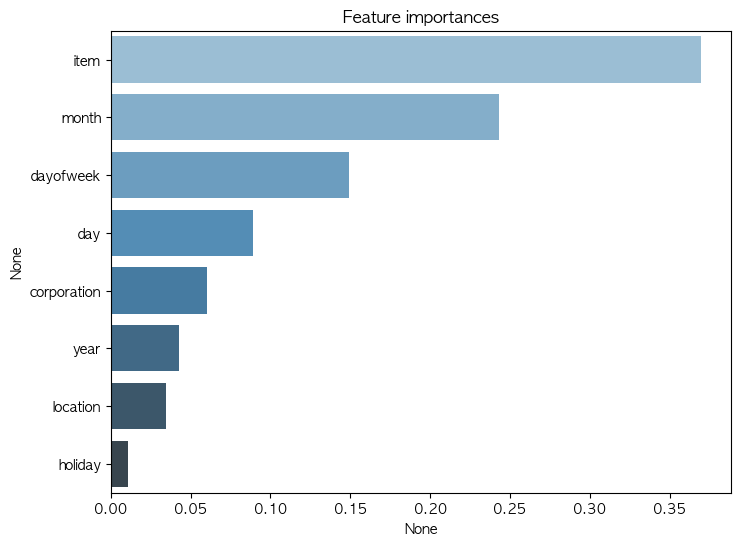

In [101]:
## Feature importances

ftr_importances_values = rf_model.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)
ftr_top = ftr_importances.sort_values(ascending=False)

# palette = sns.color_palette("Set2")
plt.figure(figsize=(8,6))
plt.title('Feature importances')
sns.barplot(x=ftr_top, y=ftr_top.index, palette="Blues_d")
plt.show()

- XGBoost

In [102]:
import xgboost as xgb
from xgboost import XGBRegressor

xgb_params = {'learning_rate': [0.3, 0.4, 0.2],   # leaning_rate: 0.3 기본값 높을수로 과적합되기 쉬움
              'n_estimators': [100, 120, 150],  # 100이 기본값
              'max_depth': [3, 5, 6, 7]}  # 기본값 6

xgb_model = GridSearchCV(XGBRegressor(random_state=42), param_grid=xgb_params, cv=5, refit='f1', n_jobs=-1, verbose=1)

# xgb_clf = XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)

pred_xgb_train = xgb_model.predict(X_train)
pred_xgb_test = xgb_model.predict(X_test)

xgb_rmse_train = np.sqrt(mean_squared_error(y_train, pred_xgb_train))
xgb_rmse_test = np.sqrt(mean_squared_error(y_test, pred_xgb_test))
print(f"RMSE 학습: {xgb_rmse_train}, 테스트: {xgb_rmse_test}")

xgb_r2_test = r2_score(y_test, pred_xgb_test)
print(f"r2_score: {xgb_r2_test}")

Fitting 5 folds for each of 36 candidates, totalling 180 fits
RMSE 학습: 693.7320985333546, 테스트: 902.9161515396447
r2_score: 0.8035604270733885


In [103]:
xgb_model.best_params_

{'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 100}

- lightGBM

In [104]:
import lightgbm as lgb

lgb_clf = lgb.LGBMRegressor(random_state=42) #num_leaves=31, objective='regression'
lgb_clf.fit(X_train, y_train)
pred_lgb_train = lgb_clf.predict(X_train)
pred_lgb_test = lgb_clf.predict(X_test)

lgb_mae_train = mean_absolute_error(y_train, pred_lgb_train)
lgb_mae_test = mean_absolute_error(y_test, pred_lgb_test)
print(f"MAE 학습: {lgb_mae_train}, 테스트: {lgb_mae_test}")

lgb_rmse_train = np.sqrt(mean_squared_error(y_train, pred_lgb_train))
lgb_rmse_test = np.sqrt(mean_squared_error(y_test, pred_lgb_test))
print(f"RMSE 학습: {lgb_rmse_train}, 테스트: {lgb_rmse_test}")

lgb_r2_test = r2_score(y_test, pred_lgb_test)
print(f"r2_score: {lgb_r2_test}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000462 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 72
[LightGBM] [Info] Number of data points in the train set: 30767, number of used features: 8
[LightGBM] [Info] Start training from score 1096.376052
MAE 학습: 370.49643813242494, 테스트: 403.26279134738945
RMSE 학습: 808.6872295452017, 테스트: 909.6952820333911
r2_score: 0.8005996013407363


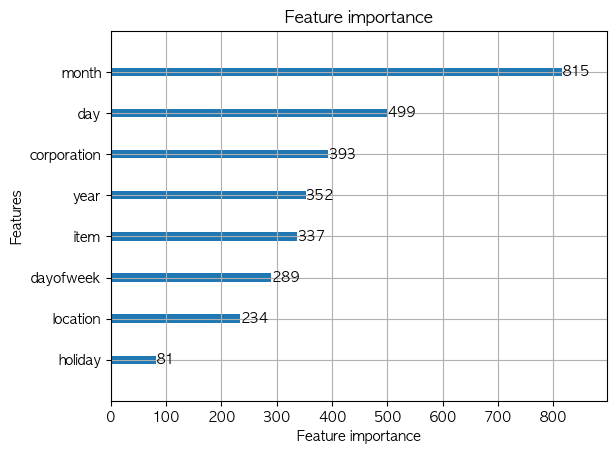

In [105]:
lgb.plot_importance(lgb_clf, max_num_features=10, importance_type='split')
plt.show()

- Catboost 

In [106]:
import catboost as cb
from catboost import CatBoostRegressor

cat_model = cb.CatBoostRegressor(random_state=42) #iterations=100, depth=10, learning_rate=0.05
cat_model.fit(X_train, y_train)

pred_cb_train = cat_model.predict(X_train)
pred_cb_test = cat_model.predict(X_test)

cb_mae_train = mean_absolute_error(y_train, pred_cb_train)
cb_mae_test = mean_absolute_error(y_test, pred_cb_test)
print(f"MAE 학습: {cb_mae_train}, 테스트: {cb_mae_test}")

cb_rmse_train = np.sqrt(mean_squared_error(y_train, pred_cb_train))
cb_rmse_test = np.sqrt(mean_squared_error(y_test,pred_cb_test))
print(f"RMSE 학습: {cb_rmse_train}, 테스트: {cb_rmse_test}")

cb_r2_test = r2_score(y_test, pred_cb_test)
print(f"r2_score: {cb_r2_test}")

Learning rate set to 0.070355
0:	learn: 1914.9538534	total: 9.09ms	remaining: 9.08s
1:	learn: 1831.8518735	total: 14.2ms	remaining: 7.07s
2:	learn: 1756.5793303	total: 16.9ms	remaining: 5.62s
3:	learn: 1685.4712207	total: 19.6ms	remaining: 4.87s
4:	learn: 1624.6942769	total: 21.9ms	remaining: 4.37s
5:	learn: 1568.7385788	total: 24.7ms	remaining: 4.09s
6:	learn: 1516.2924240	total: 27.4ms	remaining: 3.88s
7:	learn: 1469.4467505	total: 30.1ms	remaining: 3.73s
8:	learn: 1429.2173685	total: 35.9ms	remaining: 3.95s
9:	learn: 1393.3046325	total: 38.6ms	remaining: 3.82s
10:	learn: 1360.6959133	total: 41.2ms	remaining: 3.71s
11:	learn: 1329.5019503	total: 45.2ms	remaining: 3.72s
12:	learn: 1303.8912145	total: 48ms	remaining: 3.64s
13:	learn: 1281.4989079	total: 50.7ms	remaining: 3.57s
14:	learn: 1259.1378212	total: 53.4ms	remaining: 3.5s
15:	learn: 1239.4793525	total: 56.1ms	remaining: 3.45s
16:	learn: 1223.1390394	total: 58.9ms	remaining: 3.41s
17:	learn: 1207.3282132	total: 61.6ms	remaining:

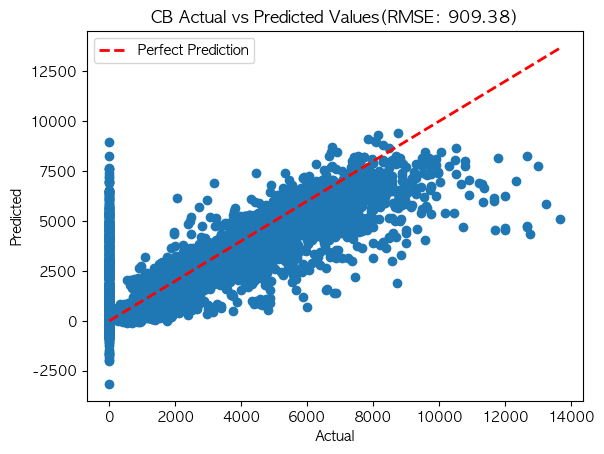

In [107]:
plt.scatter(y_test, pred_cb_test)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle='--', color='red', linewidth=2, label='Perfect Prediction')
plt.title(f'CB Actual vs Predicted Values(RMSE: {round(cb_rmse_test, 2)})')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()
plt.show()

In [108]:
ohe = OneHotEncoder(sparse_output=False)

train_encoded_features = ohe.fit_transform(df[['item','corporation','location']])
train_item_encoded_df = pd.DataFrame(train_encoded_features, columns=ohe.get_feature_names_out(['item', 'corporation', 'location']))
train_df_encoded = pd.concat([df, train_item_encoded_df], axis = 1)

print(train_df_encoded)

                    ID         ds item corporation location  supply(kg)  \
0      TG_A_J_20190101 2019-01-01   TG           A        J         0.0   
1      TG_A_J_20190102 2019-01-02   TG           A        J         0.0   
2      TG_A_J_20190103 2019-01-03   TG           A        J     60601.0   
3      TG_A_J_20190104 2019-01-04   TG           A        J     25000.0   
4      TG_A_J_20190105 2019-01-05   TG           A        J     32352.0   
...                ...        ...  ...         ...      ...         ...   
43948  RD_F_J_20220127 2022-01-27   RD           F        J    522900.0   
43949  RD_F_J_20220128 2022-01-28   RD           F        J    435800.0   
43950  RD_F_J_20220129 2022-01-29   RD           F        J    422700.0   
43951  RD_F_J_20220130 2022-01-30   RD           F        J    484440.0   
43952  RD_F_J_20220131 2022-01-31   RD           F        J         0.0   

            y  year  month  day  ...  item_RD item_TG  corporation_A  \
0         0.0  2019      1 

In [109]:
model2 = LinearRegression()
X = train_df_encoded[['year','month','day','dayofweek','item_BC','item_CB','item_CR','item_RD','item_TG','corporation_A','corporation_B','corporation_C','corporation_D','corporation_E','corporation_F','location_J','location_S']]
y = train_df_encoded[['y']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model2.fit(X_train, y_train)

LinearRegression()

In [110]:
pred_lg2_train = model2.predict(X_train)
pred_lg2_test = model2.predict(X_test)

lg2_rmse_train = np.sqrt(mean_squared_error(y_train, pred_lg2_train))
lg2_rmse_test = np.sqrt(mean_squared_error(y_test,pred_lg2_test))
print(f"RMSE 학습: {lg2_rmse_train}, 테스트: {lg2_rmse_test}")

lg2_r2_test = r2_score(y_test, pred_lg2_test)
print(f"r2_score: {lg2_r2_test}")

RMSE 학습: 1556.1713267710513, 테스트: 1589.0013864413536
r2_score: 0.3916091274500044


### 모델 별 평가지표 점수 비교

/var/folders/qv/tqmmyp0s5dj996k_tcvqmtqm0000gn/T/ipykernel_7975/2317614903.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Model', y='Test_RMSE', data=df_recap, palette='Blues_d')


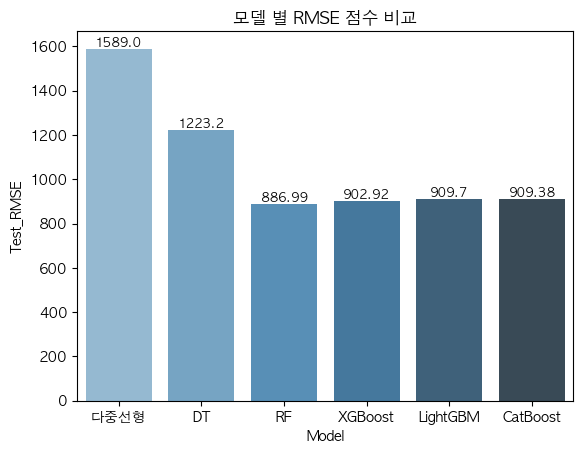

In [111]:
rmse_test = [lg2_rmse_test, dt_rmse_test, rf_rmse_test, xgb_rmse_test, lgb_rmse_test, cb_rmse_test]
recap_model = ["다중선형", "DT", "RF", "XGBoost", "LightGBM", "CatBoost"]
df_recap = pd.DataFrame({'Model':recap_model, 'Test_RMSE':rmse_test})
ax = sns.barplot(x='Model', y='Test_RMSE', data=df_recap, palette='Blues_d')
plt.title("모델 별 RMSE 점수 비교")
for i, v in enumerate(recap_model):
    plt.text(v, rmse_test[i], f"{round(rmse_test[i],2)}",
             fontsize= 9,
             horizontalalignment='center',
             verticalalignment='bottom')

## Test-Test 정답 비교

In [112]:
test_df.head()

,ID,ds,item,corporation,location,supply(kg),y,year,month,day,dayofweek,holiday
0,TG_A_J_20220201,2022-02-01,TG,A,J,0.0,0.0,2022,1,1,1,holiday
1,TG_A_J_20220202,2022-02-02,TG,A,J,0.0,0.0,2022,1,2,2,holiday
2,TG_A_J_20220203,2022-02-03,TG,A,J,0.0,0.0,2022,1,3,3,non-holiday
3,TG_A_J_20220204,2022-02-04,TG,A,J,535.5,6065.0,2022,1,4,4,non-holiday
4,TG_A_J_20220205,2022-02-05,TG,A,J,5893.0,3113.0,2022,1,5,5,non-holiday


In [113]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1092 entries, 0 to 1091
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   ID           1092 non-null   object        
 1   ds           1092 non-null   datetime64[ns]
 2   item         1092 non-null   object        
 3   corporation  1092 non-null   object        
 4   location     1092 non-null   object        
 5   supply(kg)   1092 non-null   float64       
 6   y            1092 non-null   float64       
 7   year         1092 non-null   int32         
 8   month        1092 non-null   int32         
 9   day          1092 non-null   int32         
 10  dayofweek    1092 non-null   int32         
 11  holiday      1092 non-null   object        
dtypes: datetime64[ns](1), float64(2), int32(4), object(5)
memory usage: 85.4+ KB


In [114]:
encoding_columns = ['item', 'corporation', 'location', 'holiday'] 
not_encoding_columns = ['ID', 'ds', 'y', 'year', 'month', 'day', 'dayofweek']

In [115]:
enc_classes = {}

def encoding_labels(x):
    le = LabelEncoder()
    label = le.fit_transform(x)
    enc_classes[x.name] = le.classes_
    return label

In [116]:
d1 = test_df[encoding_columns].apply(encoding_labels)
d1.head()

,item,corporation,location,holiday
0,4,0,0,0
1,4,0,0,0
2,4,0,0,1
3,4,0,0,1
4,4,0,0,1


In [117]:
d2 = test_df[not_encoding_columns]
d2

,ID,ds,y,year,month,day,dayofweek
0,TG_A_J_20220201,2022-02-01,0.0,2022,1,1,1
1,TG_A_J_20220202,2022-02-02,0.0,2022,1,2,2
2,TG_A_J_20220203,2022-02-03,0.0,2022,1,3,3
3,TG_A_J_20220204,2022-02-04,6065.0,2022,1,4,4
4,TG_A_J_20220205,2022-02-05,3113.0,2022,1,5,5
...,...,...,...,...,...,...,...
1087,RD_F_J_20220224,2022-02-24,532.0,2022,12,23,3
1088,RD_F_J_20220225,2022-02-25,520.0,2022,12,24,4
1089,RD_F_J_20220226,2022-02-26,509.0,2022,12,25,5
1090,RD_F_J_20220227,2022-02-27,0.0,2022,12,26,6


In [118]:
test_data = d1.join(d2)
test_data

,item,corporation,location,holiday,ID,ds,y,year,month,day,dayofweek
0,4,0,0,0,TG_A_J_20220201,2022-02-01,0.0,2022,1,1,1
1,4,0,0,0,TG_A_J_20220202,2022-02-02,0.0,2022,1,2,2
2,4,0,0,1,TG_A_J_20220203,2022-02-03,0.0,2022,1,3,3
3,4,0,0,1,TG_A_J_20220204,2022-02-04,6065.0,2022,1,4,4
4,4,0,0,1,TG_A_J_20220205,2022-02-05,3113.0,2022,1,5,5
...,...,...,...,...,...,...,...,...,...,...,...
1087,3,5,0,1,RD_F_J_20220224,2022-02-24,532.0,2022,12,23,3
1088,3,5,0,1,RD_F_J_20220225,2022-02-25,520.0,2022,12,24,4
1089,3,5,0,1,RD_F_J_20220226,2022-02-26,509.0,2022,12,25,5
1090,3,5,0,1,RD_F_J_20220227,2022-02-27,0.0,2022,12,26,6


In [121]:
X_new = test_data[['item', 'corporation', 'location', 'holiday', 'year', 'month', 'day', 'dayofweek']]
test_predictions = rf_model.predict(X_new)
test_predictions = np.where(test_predictions<0, 0, test_predictions)
test_data['predicted_price'] = test_predictions
test_data.head(10)


,item,corporation,location,holiday,ID,ds,y,year,month,day,dayofweek,predicted_price
0,4,0,0,0,TG_A_J_20220201,2022-02-01,0.0,2022,1,1,1,21.69
1,4,0,0,0,TG_A_J_20220202,2022-02-02,0.0,2022,1,2,2,28.92
2,4,0,0,1,TG_A_J_20220203,2022-02-03,0.0,2022,1,3,3,1787.34
3,4,0,0,1,TG_A_J_20220204,2022-02-04,6065.0,2022,1,4,4,1709.98
4,4,0,0,1,TG_A_J_20220205,2022-02-05,3113.0,2022,1,5,5,1663.42
5,4,0,0,1,TG_A_J_20220206,2022-02-06,0.0,2022,1,6,6,0.00
6,4,0,0,1,TG_A_J_20220207,2022-02-07,2298.0,2022,1,7,0,1705.13
7,4,0,0,1,TG_A_J_20220208,2022-02-08,2483.0,2022,1,8,1,1640.47
8,4,0,0,1,TG_A_J_20220209,2022-02-09,2500.0,2022,1,9,2,1585.44
9,4,0,0,1,TG_A_J_20220210,2022-02-10,2075.0,2022,1,10,3,1611.46


In [122]:
# final = test_data['ID', 'timestamp', 'price', 'predicted_price']
# final
test_data.loc[:,['ID', 'ds', 'y', 'predicted_price']].head(30)


,ID,ds,y,predicted_price
0,TG_A_J_20220201,2022-02-01,0.0,21.69
1,TG_A_J_20220202,2022-02-02,0.0,28.92
2,TG_A_J_20220203,2022-02-03,0.0,1787.34
3,TG_A_J_20220204,2022-02-04,6065.0,1709.98
4,TG_A_J_20220205,2022-02-05,3113.0,1663.42
5,TG_A_J_20220206,2022-02-06,0.0,0.00
6,TG_A_J_20220207,2022-02-07,2298.0,1705.13
7,TG_A_J_20220208,2022-02-08,2483.0,1640.47
8,TG_A_J_20220209,2022-02-09,2500.0,1585.44
9,TG_A_J_20220210,2022-02-10,2075.0,1611.46


In [123]:
test_predictions

array([  21.69,   28.92, 1787.34, ...,  534.65,    0.  ,  498.91])

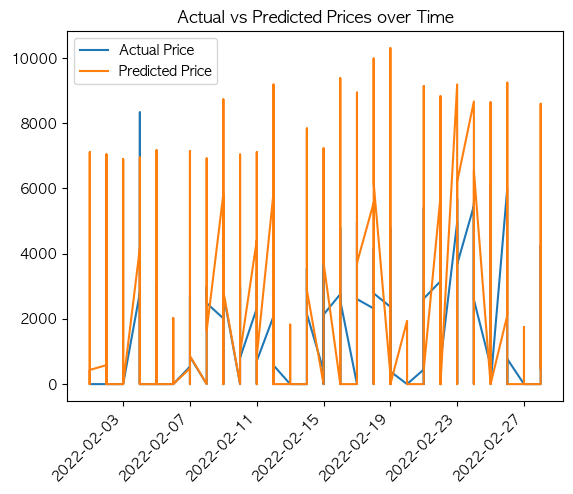

In [126]:
from matplotlib import dates

test_data_sorted = test_data.sort_values(by='ds')
plt.plot(test_data_sorted['ds'], test_data_sorted['y'], label='Actual Price')
plt.plot(test_data_sorted['ds'], test_data_sorted['predicted_price'], label='Predicted Price')
# plt.plot(test_predictions)
plt.title('Actual vs Predicted Prices over Time')
plt.xticks(rotation=45, ha="right") 
plt.legend()

ax = plt.gca()
ax.xaxis.set_major_locator(dates.DayLocator(interval=4))
plt.show()

In [ ]:
print(test_data.columns)

Index(['item', 'corporation', 'location', 'ID', 'timestamp', 'price(원/kg)',
       'year', 'month', 'day', 'dayofweek', 'predicted_price'],
      dtype='object')


shap

In [ ]:
# import shap
# explainer = shap.TreeExplainer(rf_model)
# shap_values = explainer.shap_values(X_test)

# # 특정 샘플에 대한 shap summary plot 
# shap.summary_plot(shap_values, X_test)

In [ ]:
# shap.plots.force(explainer.expected_value, shap_values)


In [ ]:
# from datetime import datetime, timedelta
# from prophet import Prophet #prophet 라이브러리 불러오기

# from prophet.diagnostics import cross_validation
# from prophet.plot import plot_cross_validation_metric
# from prophet.diagnostics import performance_metrics

/Users/hj/Documents/무제/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# import holidays
# date_list=pd.date_range(start='20190101', end='20230228', freq='D')

# # 한국 휴일 객체 생성 
# kr_holidays = holidays.KR()
# holiday_df = pd.DataFrame(columns=['ds','holiday'])
# holiday_df['ds'] = sorted(date_list)
# holiday_df['holiday'] = holiday_df.ds.apply(lambda x: 'holiday' if x in kr_holidays else 'non-holiday')

In [ ]:
# holiday_df

,ds,holiday
0,2019-01-01,holiday
1,2019-01-02,non-holiday
2,2019-01-03,non-holiday
3,2019-01-04,non-holiday
4,2019-01-05,non-holiday
...,...,...
1515,2023-02-24,non-holiday
1516,2023-02-25,non-holiday
1517,2023-02-26,non-holiday
1518,2023-02-27,non-holiday


In [ ]:
# Prophet 객체 생성
# n = Prophet(holidays=holiday_df, weekly_seasonality=True, daily_seasonality=True)

In [ ]:
df

,ID,timestamp,item,corporation,location,supply(kg),price(원/kg),year,month,day,dayofweek
0,TG_A_J_20190101,2019-01-01,TG,A,J,0.0,0.0,2019,1,1,1
1,TG_A_J_20190102,2019-01-02,TG,A,J,0.0,0.0,2019,1,2,2
2,TG_A_J_20190103,2019-01-03,TG,A,J,60601.0,1728.0,2019,1,3,3
3,TG_A_J_20190104,2019-01-04,TG,A,J,25000.0,1408.0,2019,1,4,4
4,TG_A_J_20190105,2019-01-05,TG,A,J,32352.0,1250.0,2019,1,5,5
...,...,...,...,...,...,...,...,...,...,...,...
43948,RD_F_J_20220127,2022-01-27,RD,F,J,522900.0,536.0,2022,1,27,3
43949,RD_F_J_20220128,2022-01-28,RD,F,J,435800.0,588.0,2022,1,28,4
43950,RD_F_J_20220129,2022-01-29,RD,F,J,422700.0,623.0,2022,1,29,5
43951,RD_F_J_20220130,2022-01-30,RD,F,J,484440.0,481.0,2022,1,30,6


In [ ]:
# df = df.rename(columns={'timestamp': 'ds', 'price(원/kg)':'y'})
# df

,ID,ds,item,corporation,location,supply(kg),y,year,month,day,dayofweek
0,TG_A_J_20190101,2019-01-01,TG,A,J,0.0,0.0,2019,1,1,1
1,TG_A_J_20190102,2019-01-02,TG,A,J,0.0,0.0,2019,1,2,2
2,TG_A_J_20190103,2019-01-03,TG,A,J,60601.0,1728.0,2019,1,3,3
3,TG_A_J_20190104,2019-01-04,TG,A,J,25000.0,1408.0,2019,1,4,4
4,TG_A_J_20190105,2019-01-05,TG,A,J,32352.0,1250.0,2019,1,5,5
...,...,...,...,...,...,...,...,...,...,...,...
43948,RD_F_J_20220127,2022-01-27,RD,F,J,522900.0,536.0,2022,1,27,3
43949,RD_F_J_20220128,2022-01-28,RD,F,J,435800.0,588.0,2022,1,28,4
43950,RD_F_J_20220129,2022-01-29,RD,F,J,422700.0,623.0,2022,1,29,5
43951,RD_F_J_20220130,2022-01-30,RD,F,J,484440.0,481.0,2022,1,30,6


In [ ]:
# # 모델 학습
# n.fit(df)

# #2023년 3월을 포함한 미래의 날짜값 생성(예측할 기간 설정)
# future_n = n.make_future_dataframe(periods=31, freq='d')

# #예측값 생성
# forecast_n = n.predict(future_n)

23:48:44 - cmdstanpy - INFO - Chain [1] start processing
23:48:49 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
# forecast_n

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-01-01,135.939100,-2056.530169,2894.847072,135.939100,135.939100,322.402032,322.402032,322.402032,543.8488,...,199.553207,199.553207,199.553207,-264.750476,-264.750476,-264.750476,0.0,0.0,0.0,458.341132
1,2019-01-02,136.411173,-1673.409996,3529.378387,136.411173,136.411173,790.036320,790.036320,790.036320,543.8488,...,207.008142,207.008142,207.008142,-253.031497,-253.031497,-253.031497,0.0,0.0,0.0,926.447493
2,2019-01-03,136.883246,-1654.150031,3542.098835,136.883246,136.883246,792.910019,792.910019,792.910019,543.8488,...,196.186100,196.186100,196.186100,-239.335756,-239.335756,-239.335756,0.0,0.0,0.0,929.793265
3,2019-01-04,137.355319,-1412.786280,3436.086203,137.355319,137.355319,793.029445,793.029445,793.029445,543.8488,...,180.814485,180.814485,180.814485,-223.844716,-223.844716,-223.844716,0.0,0.0,0.0,930.384764
4,2019-01-05,137.827393,-1759.114583,3232.151640,137.827393,137.827393,715.998100,715.998100,715.998100,543.8488,...,86.731955,86.731955,86.731955,-206.793531,-206.793531,-206.793531,0.0,0.0,0.0,853.825492
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1153,2022-02-27,593.595440,-2031.569983,2825.205908,591.764928,594.740250,-103.356953,-103.356953,-103.356953,543.8488,...,-1098.124530,-1098.124530,-1098.124530,158.707902,158.707902,158.707902,0.0,0.0,0.0,490.238487
1154,2022-02-28,594.809371,-556.701990,4312.868361,592.827907,596.117688,1237.185783,1237.185783,1237.185783,543.8488,...,227.830639,227.830639,227.830639,173.295469,173.295469,173.295469,0.0,0.0,0.0,1831.995154
1155,2022-03-01,596.023302,-1161.223522,3778.236812,593.822600,597.466566,773.546311,773.546311,773.546311,543.8488,...,199.553207,199.553207,199.553207,186.393804,186.393804,186.393804,0.0,0.0,0.0,1369.569613
1156,2022-03-02,597.237233,-630.220374,4254.099405,594.885672,598.866062,1241.150071,1241.150071,1241.150071,543.8488,...,207.008142,207.008142,207.008142,198.082254,198.082254,198.082254,0.0,0.0,0.0,1838.387304


In [ ]:
# # holiday_df의 'ds'와 'holiday' 컬럼을 기존의 df 데이터프레임에 추가
# df['holiday'] = df['ds'].apply(lambda x: holiday_df[holiday_df['ds'] == x]['holiday'].values[0] if x in holiday_df['ds'].values else 'non-holiday')

# # 결과 확인
# df


,ID,ds,item,corporation,location,supply(kg),y,year,month,day,dayofweek,holiday
0,TG_A_J_20190101,2019-01-01,TG,A,J,0.0,0.0,2019,1,1,1,holiday
1,TG_A_J_20190102,2019-01-02,TG,A,J,0.0,0.0,2019,1,2,2,non-holiday
2,TG_A_J_20190103,2019-01-03,TG,A,J,60601.0,1728.0,2019,1,3,3,non-holiday
3,TG_A_J_20190104,2019-01-04,TG,A,J,25000.0,1408.0,2019,1,4,4,non-holiday
4,TG_A_J_20190105,2019-01-05,TG,A,J,32352.0,1250.0,2019,1,5,5,non-holiday
...,...,...,...,...,...,...,...,...,...,...,...,...
43948,RD_F_J_20220127,2022-01-27,RD,F,J,522900.0,536.0,2022,1,27,3,non-holiday
43949,RD_F_J_20220128,2022-01-28,RD,F,J,435800.0,588.0,2022,1,28,4,non-holiday
43950,RD_F_J_20220129,2022-01-29,RD,F,J,422700.0,623.0,2022,1,29,5,non-holiday
43951,RD_F_J_20220130,2022-01-30,RD,F,J,484440.0,481.0,2022,1,30,6,non-holiday


In [ ]:
# holiday 컬럼 값 변경
# df['holiday'] = df['holiday'].apply(lambda x: 0 if x == 'holiday' else 1)

# 결과 확인
# df


,ID,ds,item,corporation,location,supply(kg),y,year,month,day,dayofweek,holiday
0,TG_A_J_20190101,2019-01-01,TG,A,J,0.0,0.0,2019,1,1,1,0
1,TG_A_J_20190102,2019-01-02,TG,A,J,0.0,0.0,2019,1,2,2,1
2,TG_A_J_20190103,2019-01-03,TG,A,J,60601.0,1728.0,2019,1,3,3,1
3,TG_A_J_20190104,2019-01-04,TG,A,J,25000.0,1408.0,2019,1,4,4,1
4,TG_A_J_20190105,2019-01-05,TG,A,J,32352.0,1250.0,2019,1,5,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...
43948,RD_F_J_20220127,2022-01-27,RD,F,J,522900.0,536.0,2022,1,27,3,1
43949,RD_F_J_20220128,2022-01-28,RD,F,J,435800.0,588.0,2022,1,28,4,1
43950,RD_F_J_20220129,2022-01-29,RD,F,J,422700.0,623.0,2022,1,29,5,1
43951,RD_F_J_20220130,2022-01-30,RD,F,J,484440.0,481.0,2022,1,30,6,1


In [ ]:
# test_df

,ID,timestamp,item,corporation,location,supply(kg),price(원/kg),year,month,day,dayofweek
0,TG_A_J_20220201,2022-02-01,TG,A,J,0.0,0.0,2022,1,1,1
1,TG_A_J_20220202,2022-02-02,TG,A,J,0.0,0.0,2022,1,2,2
2,TG_A_J_20220203,2022-02-03,TG,A,J,0.0,0.0,2022,1,3,3
3,TG_A_J_20220204,2022-02-04,TG,A,J,535.5,6065.0,2022,1,4,4
4,TG_A_J_20220205,2022-02-05,TG,A,J,5893.0,3113.0,2022,1,5,5
...,...,...,...,...,...,...,...,...,...,...,...
1087,RD_F_J_20220224,2022-02-24,RD,F,J,478500.0,532.0,2022,12,23,3
1088,RD_F_J_20220225,2022-02-25,RD,F,J,568800.0,520.0,2022,12,24,4
1089,RD_F_J_20220226,2022-02-26,RD,F,J,478320.0,509.0,2022,12,25,5
1090,RD_F_J_20220227,2022-02-27,RD,F,J,0.0,0.0,2022,12,26,6


In [ ]:
# test_df = test_df.rename(columns={'timestamp': 'ds', 'price(원/kg)':'y'})
# test_df

,ID,ds,item,corporation,location,supply(kg),y,year,month,day,dayofweek
0,TG_A_J_20220201,2022-02-01,TG,A,J,0.0,0.0,2022,1,1,1
1,TG_A_J_20220202,2022-02-02,TG,A,J,0.0,0.0,2022,1,2,2
2,TG_A_J_20220203,2022-02-03,TG,A,J,0.0,0.0,2022,1,3,3
3,TG_A_J_20220204,2022-02-04,TG,A,J,535.5,6065.0,2022,1,4,4
4,TG_A_J_20220205,2022-02-05,TG,A,J,5893.0,3113.0,2022,1,5,5
...,...,...,...,...,...,...,...,...,...,...,...
1087,RD_F_J_20220224,2022-02-24,RD,F,J,478500.0,532.0,2022,12,23,3
1088,RD_F_J_20220225,2022-02-25,RD,F,J,568800.0,520.0,2022,12,24,4
1089,RD_F_J_20220226,2022-02-26,RD,F,J,478320.0,509.0,2022,12,25,5
1090,RD_F_J_20220227,2022-02-27,RD,F,J,0.0,0.0,2022,12,26,6


In [ ]:
# # holiday_df의 'ds'와 'holiday' 컬럼을 기존의 test_df 데이터프레임에 추가
# test_df['holiday'] = test_df['ds'].apply(lambda x: holiday_df[holiday_df['ds'] == x]['holiday'].values[0] if x in holiday_df['ds'].values else 'non-holiday')

# # 결과 확인
# test_df


,ID,ds,item,corporation,location,supply(kg),y,year,month,day,dayofweek,holiday
0,TG_A_J_20220201,2022-02-01,TG,A,J,0.0,0.0,2022,1,1,1,holiday
1,TG_A_J_20220202,2022-02-02,TG,A,J,0.0,0.0,2022,1,2,2,holiday
2,TG_A_J_20220203,2022-02-03,TG,A,J,0.0,0.0,2022,1,3,3,non-holiday
3,TG_A_J_20220204,2022-02-04,TG,A,J,535.5,6065.0,2022,1,4,4,non-holiday
4,TG_A_J_20220205,2022-02-05,TG,A,J,5893.0,3113.0,2022,1,5,5,non-holiday
...,...,...,...,...,...,...,...,...,...,...,...,...
1087,RD_F_J_20220224,2022-02-24,RD,F,J,478500.0,532.0,2022,12,23,3,non-holiday
1088,RD_F_J_20220225,2022-02-25,RD,F,J,568800.0,520.0,2022,12,24,4,non-holiday
1089,RD_F_J_20220226,2022-02-26,RD,F,J,478320.0,509.0,2022,12,25,5,non-holiday
1090,RD_F_J_20220227,2022-02-27,RD,F,J,0.0,0.0,2022,12,26,6,non-holiday
